In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import argparse
from osgeo import ogr
from math import log10, ceil
from utils.point import *
from utils.extent import *
from utils.kdtree1 import *
from utils.kdtree2b import *
from utils.kfunction import *

In [6]:
def kfunc_vals(points, area):
    """
    Input
      points: a list of Point objects
      area: an Extent object

    Return
      ds: list of radii
      lds: L(d) values for each radius in ds
    """
    # This function is taken from kfunction file in spatialanalysis library
    n = len(points)
    density = n/area.area()
    t = kdtree2(points)
    d = min([area.xmax-area.xmin,area.ymax-area.ymin])*2/3/10
    ds = [ d*(i+1) for i in range(10)]
    lds = [0 for d in ds]
    for i, d in enumerate(ds):
        for p in points:
            ld = kfunc(t, p, d, density)[1]
            lds[i] += ld
    lds = [ld/n for ld in lds]
    return ds, lds

In [7]:
def kfunc_monte_carlo(n, area, radii, density, rounds=100):
    """
    Input
      n:            number of points
      area:         Extent object defining the area
      radii:        list containing a set of radii of circles
      density:      density of point events in the area
      rounds:       number of simulations
    Return
      percentiles:  a list of 2.5th and 97.5th percentiles
                    for each d in radii
    """
    alllds = []
    for test in range(rounds):
        points = [ Point(random.uniform(area.xmin, area.xmax),
                         random.uniform(area.ymin, area.ymax))
                   for i in range(n) ]
        t = kdtree2(points)
        lds = [0 for d in radii]
        for i, d in enumerate(radii):
            for p in points:
                ld = kfunc(t, p, d, density)[1]
                lds[i] += ld
        lds = [ld/n for ld in lds]
        alllds.append(lds)
    alllds = np.array(alllds)
    percentiles = []
    for i in range(len(radii)):
        percentiles.append([np.percentile(alllds[:,i], 2.5),
                            np.percentile(alllds[:,i], 97.5)])
    return percentiles

In [8]:
def plot_points(pts, area):
    """Plots the points retrieved from shapefile with help of matplotlib

    Parameters
    ----------
    pts : list of points
        list of points in shapefile.
    area : list
        area thhat includes all the points.

    """
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    x, y = [p.x for p in points], [p.y for p in points]
    ax.scatter(x, y, facecolor='#006bb3', edgecolor='#99d6ff', marker='.', alpha='0.45')
    plt.xlim(extent[0]+500000, extent[1]+500000)
    plt.ylim(extent[2]-500000, extent[3]+500000)
    plt.title("Airports in North America")
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect(1)
    plt.show()

In [9]:
def plot_graph(percentiles, ds, lds, density):
    """Generates a graphh depicting K-function.

    Parameters
    ----------
    percentiles : list
    ds : list
    lds : list
    density : float

    """
    sns.set_style('darkgrid')
    fig, ax = plt.subplots()
    plt.plot(ds, lds, color='#c61aff', label='Airports')
    plt.plot(ds, percentiles, color='#8c8c8c', linestyle='--', label='Envelope')
    plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], color='#a8000d', linestyle=':',label='L(d)=d', alpha=0.7)
    plt.title(f'K-Function ($\lambda$ = {density})')
    plt.xlabel('Radius (d)')
    plt.ylabel('L(d)')
    plt.legend(loc='best', fontsize=9)
    ax.set_aspect(1)
    plt.show()

In [13]:
driver = ogr.GetDriverByName("ESRI Shapefile")
fname = 'data/airports_2.shp'

In [14]:
airport_points = driver.Open(fname, 0)
layer = airport_points.GetLayer(0)

In [15]:
extent = layer.GetExtent()
area = area = Extent(extent[0], extent[1], extent[2], extent[3])

In [16]:
points = []
for i in range(layer.GetFeatureCount()):
    feature = layer.GetFeature(i)
    p = feature.GetGeometryRef()
    points.append(Point(p.GetPoint(0)[0], p.GetPoint(0)[1]))

In [17]:
density = float(len(points)) / area.area()

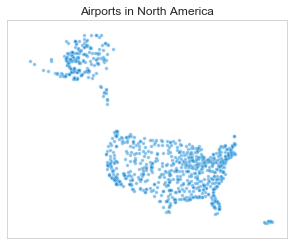

In [18]:
plot_points(points, area)

In [20]:
ds, lds = kfunc_vals(points, area)
percentiles = kfunc_monte_carlo(len(points), area, ds, density, rounds=10)

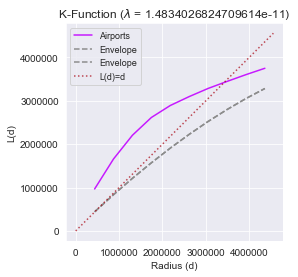

In [21]:
plot_graph(percentiles, ds, lds, density)